# Comments Sentiment
##### Analyze the comments sentiment data.

In [17]:
%pip install kaleido

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import re

spark = SparkSession.builder.getOrCreate()

sentiment_path = "s3://yt-analytics-cs6705-data/curated/comments_sentiment/"
comments_path = "s3://yt-analytics-cs6705-data/curated/comments/"
trending_path = "s3://yt-analytics-cs6705-data/curated/trending/"

sentiment_df = spark.read.parquet(sentiment_path)
comments_df = spark.read.parquet(comments_path)
trending_df = spark.read.parquet(trending_path)

sentiment_df.printSchema()
comments_df.printSchema()
trending_df.printSchema()

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [kaleido]m5/9 [pytest]
Note: you may need to restart the kernel to use updated packages.
root
 |-- video_id: string (nullable = true)
 |-- avg_comment_sent_pos: double (nullable = true)
 |-- avg_comment_sent_neg: double (nullable = true)
 |-- avg_comment_sent_neu: double (nullable = true)
 |-- avg_comment_sent_mix: double (nullable = true)
 |-- net_comment_sentiment: double (nullable = true)
 |-- comment_count_scored: long (nullable = true)
 |-- region: string (nullable = true)
 |-- ingest_date: date (nullable = true)

root
 |-- video_id: string (nullable = true)
 |-- author_display_name: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- like_count: long (nullable = true)
 |-- published_at: string (nullable = true)
 |-- region: string (nullable = true)
 |-- ingest_date: date (nullable = true)

root
 |-- video_id: string (nullable = true)


####  Define "top trending videos"


In [18]:
TOP_N = 50  # tweak as needed

top_trending_df = (
    trending_df
    .orderBy(F.desc("view_count"))
    .limit(TOP_N)
)


#### Aggregate highest comment sentiment per video


In [19]:
from pyspark.sql import functions as F

# sentiment_df schema:
# video_id: string
# avg_comment_sent_pos: double
# avg_comment_sent_neg: double
# avg_comment_sent_neu: double
# avg_comment_sent_mix: double
# net_comment_sentiment: double
# comment_count_scored: long
# region: string
# ingest_date: date



# Option 1: use net_comment_sentiment directly as "overall" sentiment
sentiment_overall = (
    sentiment_df
    .select(
        "video_id",
        "region",
        "net_comment_sentiment",
        "avg_comment_sent_pos",
        "avg_comment_sent_neg",
        "avg_comment_sent_neu",
        "avg_comment_sent_mix",
        "comment_count_scored",
        "ingest_date"
    )
    .withColumnRenamed("net_comment_sentiment", "max_comment_sentiment")
)

# (Optional) Option 2: also compute the dominant sentiment label
sentiment_with_label = (
    sentiment_overall
    .withColumn(
        "max_avg_sentiment",
        F.greatest(
            "avg_comment_sent_pos",
            "avg_comment_sent_neg",
            "avg_comment_sent_neu",
            "avg_comment_sent_mix",
        )
    )
    .withColumn(
        "dominant_sentiment",
        F.when(F.col("max_avg_sentiment") == F.col("avg_comment_sent_pos"), "positive")
         .when(F.col("max_avg_sentiment") == F.col("avg_comment_sent_neg"), "negative")
         .when(F.col("max_avg_sentiment") == F.col("avg_comment_sent_neu"), "neutral")
         .when(F.col("max_avg_sentiment") == F.col("avg_comment_sent_mix"), "mixed")
         .otherwise("unknown")
    )
    .drop("max_avg_sentiment")
)


In [20]:
# If your trending_df also has region, join on both:
# join_keys = ["video_id", "region"]
join_keys = ["video_id"]  # adjust if trending has region

top_with_sentiment = (
    top_trending_df.alias("t")
    .join(sentiment_with_label.alias("s"), on=join_keys, how="left")
    .select(
        "t.video_id",
        "t.title",
        "t.view_count",
        "t.like_count",
        "t.comment_count",
        "s.max_comment_sentiment",
        "s.dominant_sentiment",
        "s.comment_count_scored"
    )
    .orderBy(F.desc("max_comment_sentiment"))
)

top_with_sentiment.show(50, truncate=False)

+-----------+----------------------------------------------------------------------------------------------------+----------+----------+-------------+---------------------+------------------+--------------------+
|video_id   |title                                                                                               |view_count|like_count|comment_count|max_comment_sentiment|dominant_sentiment|comment_count_scored|
+-----------+----------------------------------------------------------------------------------------------------+----------+----------+-------------+---------------------+------------------+--------------------+
|llAI08UYyAw|Stray Kids "Do It (Overdrive Version)" M/V                                                          |2150636   |320984    |10319        |0.7875190819562582   |positive          |150                 |
|llAI08UYyAw|Stray Kids "Do It (Overdrive Version)" M/V                                                          |2150636   |320984    |10319       

#### Display in your notebook


In [21]:

top_with_sentiment.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- view_count: long (nullable = true)
 |-- like_count: long (nullable = true)
 |-- comment_count: long (nullable = true)
 |-- max_comment_sentiment: double (nullable = true)
 |-- dominant_sentiment: string (nullable = true)
 |-- comment_count_scored: long (nullable = true)


In [22]:
pdf = top_with_sentiment.toPandas()
display(pdf)   # in EMR Studio / Glue Studio


NameError: name 'display' is not defined


In [8]:
sentiment_counts = (
    top_with_sentiment.groupBy("dominant_sentiment")
      .agg(F.count("*").alias("total_trending_videos"))
      .orderBy("dominant_sentiment")
)

sentiment_counts.show(truncate=False)


+------------------+---------------------+
|dominant_sentiment|total_trending_videos|
+------------------+---------------------+
|null              |9                    |
|negative          |1                    |
|neutral           |3                    |
|positive          |20                   |
+------------------+---------------------+


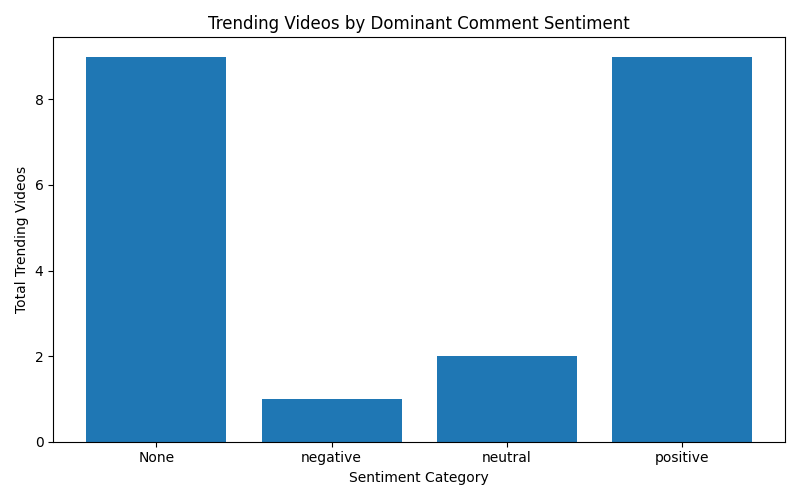

In [13]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1. Aggregate trending-video counts per sentiment
sentiment_counts = (
    top_with_sentiment.groupBy("dominant_sentiment")
      .agg(F.countDistinct("video_id").alias("total_trending_videos"))
      .orderBy("dominant_sentiment")
)

# 2. Convert to Pandas
pdf = sentiment_counts.toPandas()

# 3. Ensure x-axis values are strings
pdf["dominant_sentiment"] = pdf["dominant_sentiment"].astype(str)

# 4. Plot
plt.figure(figsize=(8, 5))

plt.bar(
    pdf["dominant_sentiment"],
    pdf["total_trending_videos"]
)

plt.xlabel("Sentiment Category")
plt.ylabel("Total Trending Videos")
plt.title("Trending Videos by Dominant Comment Sentiment")

plt.xticks(rotation=0)
plt.tight_layout()

%matplot plt


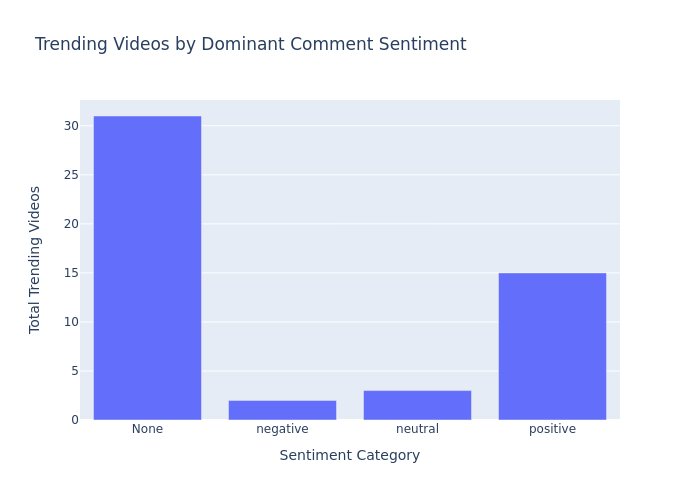

In [23]:
from pyspark.sql import functions as F
import plotly.express as px

# 1. Aggregate trending-video counts per sentiment
sentiment_counts = (
    top_with_sentiment.groupBy("dominant_sentiment")
      .agg(F.countDistinct("video_id").alias("total_trending_videos"))
      .orderBy("dominant_sentiment")
)

# 2. Convert to Pandas for Plotly
pdf = sentiment_counts.toPandas()

# 3. Ensure strings for x-axis categories
pdf["dominant_sentiment"] = pdf["dominant_sentiment"].astype(str)

# 4. Interactive bar chart
fig = px.bar(
    pdf,
    x="dominant_sentiment",
    y="total_trending_videos",
    title="Trending Videos by Dominant Comment Sentiment",
    labels={
        "dominant_sentiment": "Sentiment Category",
        "total_trending_videos": "Total Trending Videos"
    }
)

%plotly fig


In [27]:
from pyspark.sql import functions as F
import plotly.express as px

# 1) Create per-video metrics: like_ratio and comment_view_ratio
df_metrics = (
    top_with_sentiment
    .withColumn(
        "like_ratio",
        F.when(F.col("view_count") > 0,
               F.col("like_count") / F.col("view_count"))
         .otherwise(None)
    )
    .withColumn(
        "comment_view_ratio",
        F.when(F.col("view_count") > 0,
               F.col("comment_count") / F.col("view_count"))
         .otherwise(None)
    )
)

# 2) Aggregate by sentiment
agg_by_sentiment = (
    df_metrics
    .groupBy("dominant_sentiment")
    .agg(
        F.avg("view_count").alias("avg_view_count"),
        F.avg("like_ratio").alias("avg_like_ratio"),
        F.avg("comment_view_ratio").alias("avg_comment_view_ratio")
    )
    .orderBy("dominant_sentiment")
)

# 3) Convert to Pandas for Plotly
pdf = agg_by_sentiment.toPandas()
pdf["dominant_sentiment"] = pdf["dominant_sentiment"].astype(str)






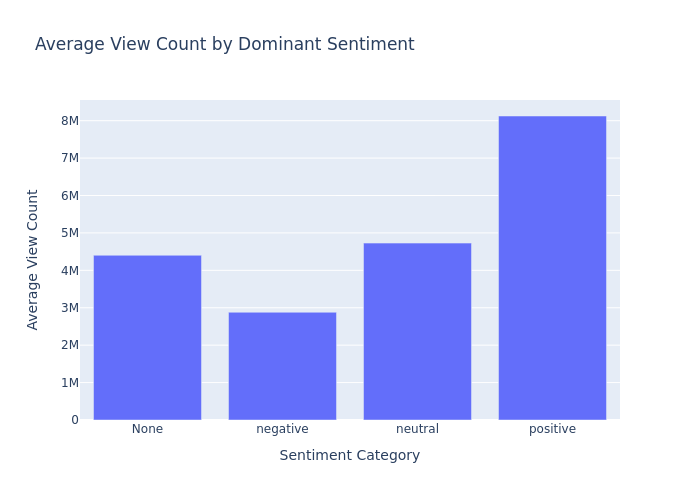

In [28]:
# === Plot 1: Average view count per sentiment ===
fig1 = px.bar(
    pdf,
    x="dominant_sentiment",
    y="avg_view_count",
    title="Average View Count by Dominant Sentiment",
    labels={
        "dominant_sentiment": "Sentiment Category",
        "avg_view_count": "Average View Count"
    }
)
%plotly fig1


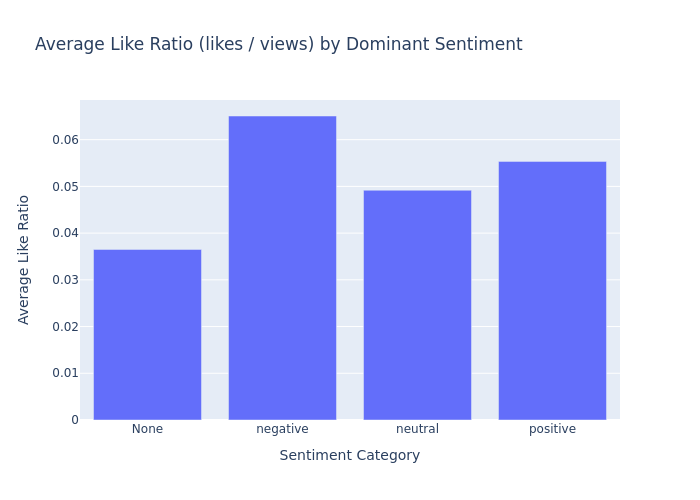

In [29]:
# === Plot 2: Average like ratio per sentiment ===
fig2 = px.bar(
    pdf,
    x="dominant_sentiment",
    y="avg_like_ratio",
    title="Average Like Ratio (likes / views) by Dominant Sentiment",
    labels={
        "dominant_sentiment": "Sentiment Category",
        "avg_like_ratio": "Average Like Ratio"
    }
)
%plotly fig2

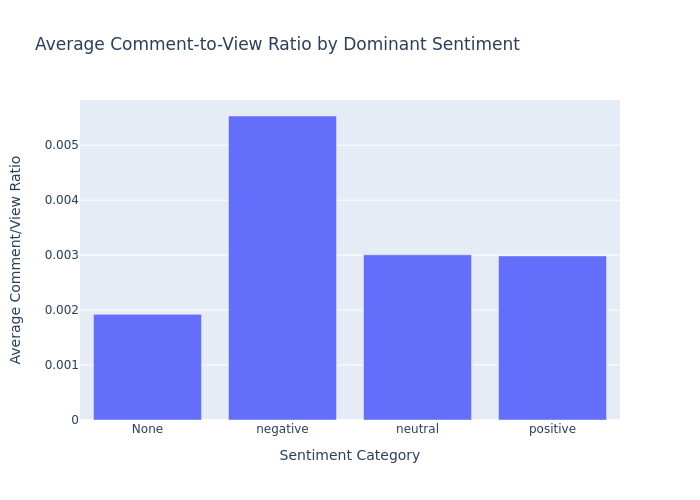

In [30]:
# === Plot 3: Average comment/view ratio per sentiment ===
fig3 = px.bar(
    pdf,
    x="dominant_sentiment",
    y="avg_comment_view_ratio",
    title="Average Comment-to-View Ratio by Dominant Sentiment",
    labels={
        "dominant_sentiment": "Sentiment Category",
        "avg_comment_view_ratio": "Average Comment/View Ratio"
    }
)
%plotly fig3